In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/sniafas/vyronas-database")

Dataset URL: https://www.kaggle.com/datasets/sniafas/vyronas-database


100%|██████████| 154M/154M [00:02<00:00, 64.2MB/s]


In [2]:
import os
from sklearn.model_selection import train_test_split

real_images_dir = 'vyronas-database/Vyronasdbmin'
sketches_dir = '/content/drive/MyDrive/Pix2Pix_Buildings/sketches_images'

# List of all real images
real_images_list = os.listdir(real_images_dir)

# Create pairs of (real_image, corresponding_sketch)
paired_images = []
for image in real_images_list:
    sketch = image[:-4] + '_sketch.jpg'  # Adjust if there's a different naming convention
    if sketch in os.listdir(sketches_dir):
        paired_images.append((image, sketch))

# Split the pairs into training and validation sets
train_pairs, val_pairs = train_test_split(paired_images, test_size=0.06, random_state=10)

# Separate the pairs into lists of real images and sketches for each set
train_real_images = [pair[0] for pair in train_pairs]
train_sketch_images = [pair[1] for pair in train_pairs]

val_real_images = [pair[0] for pair in val_pairs]
val_sketch_images = [pair[1] for pair in val_pairs]


In [6]:
train_real_images_dir = 'train/real'
train_sketches_dir = 'train/sketches'
val_real_images_dir = 'val/real'
val_sketches_dir = 'val/sketches'

In [7]:
os.makedirs(train_real_images_dir, exist_ok=True)
os.makedirs(train_sketches_dir, exist_ok=True)

os.makedirs(val_real_images_dir, exist_ok=True)
os.makedirs(val_sketches_dir, exist_ok=True)

In [8]:
for image in train_real_images:
    shutil.copy(f'{real_images_dir}/{image}', f'{train_real_images_dir}/{image}')

for image in train_sketch_images:
    shutil.copy(f'{sketches_dir}/{image}', f'{train_sketches_dir}/{image}')

for image in val_real_images:
    shutil.copy(f'{real_images_dir}/{image}', f'{val_real_images_dir}/{image}')

for image in val_sketch_images:
    shutil.copy(f'{sketches_dir}/{image}', f'{val_sketches_dir}/{image}')

In [ ]:
!rm -f /content/val/real/*

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import config
from buildings_dataset import MapDataset
from utils import save_checkpoint, load_checkpoint, save_some_examples
from generator import Generator
from discriminator import Discriminator
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image

def train_fn(disc, gen, loader, opt_disc, opt_gen, l1, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(config.DEVICE), y.to(config.DEVICE)

        # Train the Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_fake = disc(x, y_fake.detach())
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2  # to make the discriminator train slower relative to the generator

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train the Generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1(y_fake, y) * config.L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Update the tqdm loop description to display the losses
        loop.set_description(f"Epoch [{epoch}/{config.NUM_EPOCHS}]")
        loop.set_postfix(D_loss=D_loss.item(), G_loss=G_loss.item())
    return D_loss, G_loss


In [5]:
disc = Discriminator(in_channels=3).to(config.DEVICE)
gen = Generator(in_channels=3).to(config.DEVICE)
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

if config.LOAD_MODEL:
    load_checkpoint(config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE)
    load_checkpoint(config.CHECKPOINT_DISC, disc, opt_disc, config.LEARNING_RATE)

train_dataset = MapDataset(real_images_dir='/content/train/real', sketches_dir = '/content/train/sketches')
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

val_dataset = MapDataset(real_images_dir='/content/val/real', sketches_dir = '/content/val/sketches')
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

discriminator_loss = []
generator_loss = []
for epoch in range(351):
    disc_epoch_loss, gen_epoch_loss = train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
    discriminator_loss.append(disc_epoch_loss)
    generator_loss.append(gen_epoch_loss)

    if epoch % 5 == 0:
        save_some_examples(gen, val_loader, epoch, folder='/content/drive/MyDrive/Pix2Pix_Buildings/evaluation')
        save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=config.CHECKPOINT_DISC)

Epoch [0/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.716, G_loss=32.3]


=> Saving checkpoint
=> Saving checkpoint


Epoch [5/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.53, G_loss=28.9]


=> Saving checkpoint
=> Saving checkpoint


Epoch [10/351]: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, D_loss=0.606, G_loss=22.5]


=> Saving checkpoint
=> Saving checkpoint


Epoch [15/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.639, G_loss=20.1]


=> Saving checkpoint
=> Saving checkpoint


Epoch [20/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.704, G_loss=15.3]


=> Saving checkpoint
=> Saving checkpoint


Epoch [25/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.634, G_loss=14.6]


=> Saving checkpoint
=> Saving checkpoint


Epoch [30/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.636, G_loss=15.3]


=> Saving checkpoint
=> Saving checkpoint


Epoch [35/351]: 100%|██████████| 22/22 [00:25<00:00,  1.16s/it, D_loss=0.569, G_loss=14.4]


=> Saving checkpoint
=> Saving checkpoint


Epoch [40/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.397, G_loss=14.9]


=> Saving checkpoint
=> Saving checkpoint


Epoch [45/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.225, G_loss=13.8]


=> Saving checkpoint
=> Saving checkpoint


Epoch [50/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.738, G_loss=12]


=> Saving checkpoint
=> Saving checkpoint


Epoch [55/351]: 100%|██████████| 22/22 [00:25<00:00,  1.16s/it, D_loss=0.0926, G_loss=14]


=> Saving checkpoint
=> Saving checkpoint


Epoch [60/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.757, G_loss=9.45]


=> Saving checkpoint
=> Saving checkpoint


Epoch [65/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.45, G_loss=9.56]


=> Saving checkpoint
=> Saving checkpoint


Epoch [70/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.125, G_loss=11]


=> Saving checkpoint
=> Saving checkpoint


Epoch [75/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.0331, G_loss=12.8]


=> Saving checkpoint
=> Saving checkpoint


Epoch [80/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.0432, G_loss=10.9]


=> Saving checkpoint
=> Saving checkpoint


Epoch [85/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.253, G_loss=11.3]


=> Saving checkpoint
=> Saving checkpoint


Epoch [90/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.0286, G_loss=11.8]


=> Saving checkpoint
=> Saving checkpoint


Epoch [95/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.0157, G_loss=12]


=> Saving checkpoint
=> Saving checkpoint


Epoch [100/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.261, G_loss=9.09]


=> Saving checkpoint
=> Saving checkpoint


Epoch [105/351]: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, D_loss=0.0133, G_loss=11.3]


=> Saving checkpoint
=> Saving checkpoint


Epoch [110/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.693, G_loss=7.75]


=> Saving checkpoint
=> Saving checkpoint


Epoch [115/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.03, G_loss=11.7]


=> Saving checkpoint
=> Saving checkpoint


Epoch [120/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.0164, G_loss=12.4]


=> Saving checkpoint
=> Saving checkpoint


Epoch [125/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.671, G_loss=8.34]


=> Saving checkpoint
=> Saving checkpoint


Epoch [130/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.032, G_loss=11.5]


=> Saving checkpoint
=> Saving checkpoint


Epoch [135/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.00931, G_loss=11.7]


=> Saving checkpoint
=> Saving checkpoint


Epoch [140/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.033, G_loss=11.6]


=> Saving checkpoint
=> Saving checkpoint


Epoch [145/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.00989, G_loss=12.2]


=> Saving checkpoint
=> Saving checkpoint


Epoch [150/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.181, G_loss=10.4]


=> Saving checkpoint
=> Saving checkpoint


Epoch [155/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.0209, G_loss=12.1]


=> Saving checkpoint
=> Saving checkpoint


Epoch [160/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.00912, G_loss=12.3]


=> Saving checkpoint
=> Saving checkpoint


Epoch [165/351]: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, D_loss=0.782, G_loss=6.9]


=> Saving checkpoint
=> Saving checkpoint


Epoch [170/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.13, G_loss=9.29]


=> Saving checkpoint
=> Saving checkpoint


Epoch [175/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.0753, G_loss=12.1]


=> Saving checkpoint
=> Saving checkpoint


Epoch [180/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.176, G_loss=8.68]


=> Saving checkpoint
=> Saving checkpoint


Epoch [185/351]: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, D_loss=0.0726, G_loss=11.2]


=> Saving checkpoint
=> Saving checkpoint


Epoch [190/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.016, G_loss=11]


=> Saving checkpoint
=> Saving checkpoint


Epoch [195/351]: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, D_loss=0.804, G_loss=6.42]


=> Saving checkpoint
=> Saving checkpoint


Epoch [200/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.693, G_loss=5.54]


=> Saving checkpoint
=> Saving checkpoint


Epoch [205/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.626, G_loss=6]


=> Saving checkpoint
=> Saving checkpoint


Epoch [210/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.654, G_loss=7.8]


=> Saving checkpoint
=> Saving checkpoint


Epoch [215/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.0194, G_loss=10.5]


=> Saving checkpoint
=> Saving checkpoint


Epoch [220/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.00909, G_loss=10.6]


=> Saving checkpoint
=> Saving checkpoint


Epoch [225/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.00734, G_loss=11.3]


=> Saving checkpoint
=> Saving checkpoint


Epoch [230/351]: 100%|██████████| 22/22 [00:25<00:00,  1.16s/it, D_loss=0.0417, G_loss=9.95]


=> Saving checkpoint
=> Saving checkpoint


Epoch [235/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.0121, G_loss=11.7]


=> Saving checkpoint
=> Saving checkpoint


Epoch [240/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.113, G_loss=9.07]


=> Saving checkpoint
=> Saving checkpoint


Epoch [245/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.00781, G_loss=11.5]


=> Saving checkpoint
=> Saving checkpoint


Epoch [250/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.693, G_loss=5.98]


=> Saving checkpoint
=> Saving checkpoint


Epoch [255/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.158, G_loss=8.83]


=> Saving checkpoint
=> Saving checkpoint


Epoch [260/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.0149, G_loss=10.5]


=> Saving checkpoint
=> Saving checkpoint


Epoch [265/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.685, G_loss=5.88]


=> Saving checkpoint
=> Saving checkpoint


Epoch [270/351]: 100%|██████████| 22/22 [00:23<00:00,  1.09s/it, D_loss=0.776, G_loss=7.16]


=> Saving checkpoint
=> Saving checkpoint


Epoch [275/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.0118, G_loss=10.7]


=> Saving checkpoint
=> Saving checkpoint


Epoch [280/351]: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, D_loss=0.157, G_loss=9.36]


=> Saving checkpoint
=> Saving checkpoint


Epoch [285/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.0313, G_loss=10.4]


=> Saving checkpoint
=> Saving checkpoint


Epoch [290/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.0245, G_loss=10.9]


=> Saving checkpoint
=> Saving checkpoint


Epoch [295/351]: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, D_loss=0.15, G_loss=8.8]


=> Saving checkpoint
=> Saving checkpoint


Epoch [300/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.00694, G_loss=10.9]


=> Saving checkpoint
=> Saving checkpoint


Epoch [305/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.00654, G_loss=11.3]


=> Saving checkpoint
=> Saving checkpoint


Epoch [310/351]: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, D_loss=0.00716, G_loss=12.2]


=> Saving checkpoint
=> Saving checkpoint


Epoch [315/351]: 100%|██████████| 22/22 [00:25<00:00,  1.14s/it, D_loss=0.553, G_loss=6.84]


=> Saving checkpoint
=> Saving checkpoint


Epoch [320/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.684, G_loss=5.29]


=> Saving checkpoint
=> Saving checkpoint


Epoch [325/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.673, G_loss=5.48]


=> Saving checkpoint
=> Saving checkpoint


Epoch [330/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.019, G_loss=9.33]


=> Saving checkpoint
=> Saving checkpoint


Epoch [335/351]: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, D_loss=0.00905, G_loss=10.8]


=> Saving checkpoint
=> Saving checkpoint


Epoch [340/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.00913, G_loss=11.1]


=> Saving checkpoint
=> Saving checkpoint


Epoch [345/351]: 100%|██████████| 22/22 [00:25<00:00,  1.15s/it, D_loss=0.00508, G_loss=11.6]


=> Saving checkpoint
=> Saving checkpoint


Epoch [350/351]: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it, D_loss=0.00597, G_loss=11.4]


=> Saving checkpoint
=> Saving checkpoint


In [9]:
print((discriminator_loss[0]))

tensor(0.7162, device='cuda:0', grad_fn=<DivBackward0>)


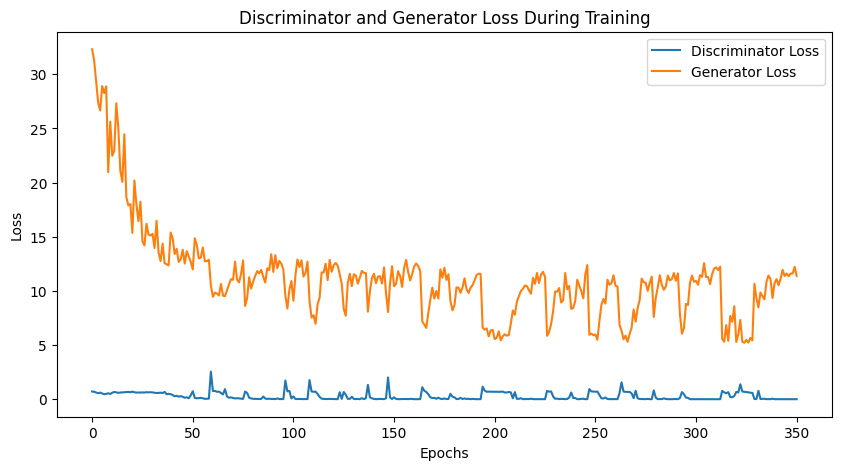

In [10]:
import matplotlib.pyplot as plt

# Convert tensors to floats before plotting
discriminator_loss_floats = [loss.item() for loss in discriminator_loss]
generator_loss_floats = [loss.item() for loss in generator_loss]

# Plotting the discriminator and generator losses
plt.figure(figsize=(10, 5))
plt.plot(discriminator_loss_floats, label="Discriminator Loss")
plt.plot(generator_loss_floats, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Loss During Training")
plt.legend()
plt.show()


In [13]:
import pickle

# Save the discriminator and generator losses to a file
with open('/content/drive/MyDrive/Pix2Pix_Buildings/Model/losses.pkl', 'wb') as f:
    pickle.dump({'discriminator_loss': discriminator_loss_floats, 'generator_loss': generator_loss_floats}, f)


In [ ]:
from google.colab import files

# Name of the folder to download
folder_to_download = 'evaluation'

# Zip the folder
!zip -r results.zip {folder_to_download}

# Download the zipped folder
files.download('results.zip')